In [27]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict
from dotenv import load_dotenv
import os

In [28]:
load_dotenv() # Load environment variables from .env file

True

In [29]:
# State definitions

class BatsmanState(TypedDict):
    
    runs: int
    balls: int
    fours: int
    sixes: int

    strike_rate: float
    boundary_per_ball: float
    boundary_percentage: float
    summary: str


Parallel workflows in LangGraph:
- Execute multiple nodes concurrently.
- Send only partial state (dict subset) to each node for efficiency and correctness.
- Sending full or wrong state may cause errors due to state schema mismatch.
- LangGraph merges all node outputs back into the main state automatically.



In [30]:
def calculate_strike_rate(state: BatsmanState) -> BatsmanState:
     
    runs = state['runs']
    balls = state['balls']
     
    if balls == 0:
        sr  = 0.0
    else:
         sr = (runs / balls) * 100

    return  {'strike_rate': sr}


In [31]:
def calculate_boundary_per_ball(state: BatsmanState) -> BatsmanState:
    
    fours = state['fours']
    sixes = state['sixes']
    balls = state['balls']
    
    total_boundaries = fours + sixes
    
    if balls == 0:
        boundary_per_ball = 0.0
    else:
        boundary_per_ball = total_boundaries / balls
        
    return  {'boundary_per_ball': boundary_per_ball}

In [32]:
def calculate_boundary_percentage(state: BatsmanState) -> BatsmanState:
    
    runs = state['runs']
    fours = state['fours']
    sixes = state['sixes']
    
    boundary_runs = (fours * 4) + (sixes * 6)
    
    if runs == 0:
        boundary_percentage = 0.0
    else:
        boundary_percentage = (boundary_runs / runs) * 100
        
    return  {'boundary_percentage': boundary_percentage}

In [33]:
def summary_node(state: BatsmanState) -> BatsmanState:

    summary = f"""
    Batsman Performance Summary:
    - Runs Scored: {state['runs']}
    - Balls Faced: {state['balls']}
    - Fours Hit: {state['fours']}
    - Sixes Hit: {state['sixes']}
    - Strike Rate: {state['strike_rate']:.2f}
    - Boundaries per Ball: {state['boundary_per_ball']:.4f}
    - Boundary Percentage: {state['boundary_percentage']:.2f}%
    """
    
    return {'summary': summary}
    
    

# WorkFlow 

<img src="par.png" width = 400px, height = 300px>

In [34]:
graph = StateGraph(BatsmanState)


# Nodes definition

graph.add_node("calculate_strike_rate", calculate_strike_rate)
graph.add_node("calculate_boundary_per_ball", calculate_boundary_per_ball)
graph.add_node("calculate_boundary_percentage", calculate_boundary_percentage)
graph.add_node('Summary', summary_node)

# Edges definition

graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_boundary_per_ball")
graph.add_edge(START, "calculate_boundary_percentage")


graph.add_edge("calculate_strike_rate", "Summary")
graph.add_edge("calculate_boundary_per_ball", "Summary")
graph.add_edge("calculate_boundary_percentage", "Summary")


graph.add_edge("Summary", END)


# compile the graph

workflow  = graph.compile()

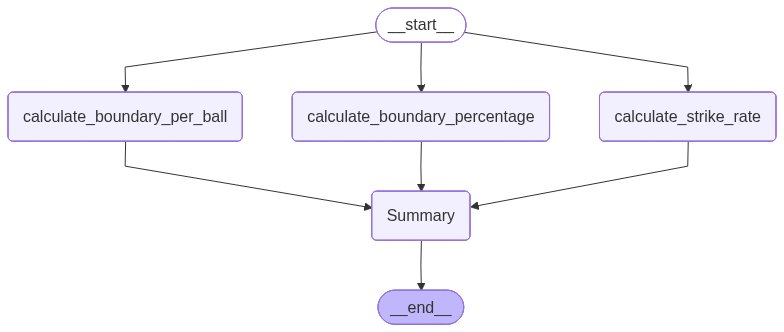

In [35]:
workflow

In [36]:
# intial state

intial_state = {
    'runs': 120,
    'balls': 80,
    'fours': 10,
    'sixes': 5
}

In [37]:
# execute the graph

final_state = workflow.invoke(intial_state) 

In [38]:
print(final_state['summary'])


    Batsman Performance Summary:
    - Runs Scored: 120
    - Balls Faced: 80
    - Fours Hit: 10
    - Sixes Hit: 5
    - Strike Rate: 150.00
    - Boundaries per Ball: 0.1875
    - Boundary Percentage: 58.33%
    
